### Word2Vec - Skip Gram Model

Skip Gram model is implemented using tensorflow in this notebook.

For more information on this model, refer to following:
1. <a href = "https://arxiv.org/pdf/1301.3781.pdf">Efficient Estimation of Word Representations in Vector Space</a>
2. <a href = "https://arxiv.org/pdf/1310.4546.pdf">Distributed Representations of Words and Phrases and their Compositionality</a>

#### 1. Input Data

In [1]:
sentences = ['king is a strong man',
             'queen is a wise woman',
             'boy is a young man',
             'girl is a young woman',
             'prince is a young king',
             'princess is a young queen',
             'man is strong',
             'woman is pretty',
             'prince is a boy will be king',
             'princess is a girl will be queen'
            ]

#### 2. Getting rid of stopwords

In [2]:
def remove_stopwords(sentences):
    stopwords = {"is", "a", "will", "be"}
    
    transformed_sentences = []
    for idx, sentence in enumerate(sentences):
        result = list()
        for word in sentence.split(" "):
            if word in stopwords:
                continue
            result.append(word)
        transformed_sentences.append(" ".join(result))
    return transformed_sentences

In [3]:
sentences = remove_stopwords(sentences)

#### 3. Creating Vocabulary

In [4]:
vocabulary = set()
for sentence in sentences:
    for word in sentence.split(" "):
        vocabulary.add(word)

print("Size of the vocabulary: {}".format(len(vocabulary)))
print("Vocabulary: {}".format(vocabulary))

Size of the vocabulary: 12
Vocabulary: {'king', 'prince', 'boy', 'wise', 'strong', 'girl', 'pretty', 'queen', 'man', 'princess', 'young', 'woman'}


#### 4. Data Preparation

In [5]:
wordPos = dict()
for idx, word in enumerate(vocabulary):
    wordPos[word] = idx

sentences = [sentence.split(" ") for sentence in sentences]

m = 2     # Window Size for the context words
data = []
for sentence in sentences:
    for i, word in enumerate(sentence):
        for context in sentence[max(i-m, 0): min(i+m, len(sentence))+1]:
            if context != word:
                data.append([word, context])

In [6]:
import pandas as pd

data = pd.DataFrame(data, columns = ["Word", "Context"])
print(data.head())

     Word Context
0    king  strong
1    king     man
2  strong    king
3  strong     man
4     man    king


In [7]:
print(data.shape)

(52, 2)


In [8]:
wordPos

{'king': 0,
 'prince': 1,
 'boy': 2,
 'wise': 3,
 'strong': 4,
 'girl': 5,
 'pretty': 6,
 'queen': 7,
 'man': 8,
 'princess': 9,
 'young': 10,
 'woman': 11}

#### 5. Defining model using tensorflow

In [9]:
import tensorflow as tf
import numpy as np

In [10]:
vocab_size = len(vocabulary)

def to_one_hot_vector(pos):
    one_hot_vector = np.zeros(vocab_size)
    one_hot_vector[pos] = 1
    
    return one_hot_vector

In [11]:
X = []
y = []

for xi, yi in data.values:
    X.append(to_one_hot_vector(wordPos[xi]))
    y.append(to_one_hot_vector(wordPos[yi]))
    
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(52, 12)
(52, 12)


In [12]:
X_input = tf.placeholder(tf.float32, shape = (None, vocab_size))
y_input = tf.placeholder(tf.float32, shape = (None, vocab_size))

word2vec_dimension = 2

w1 = tf.Variable(tf.random_normal([vocab_size, word2vec_dimension]))
b1 = tf.Variable(tf.random_normal([1]))
hidden_layer = tf.add(tf.matmul(X_input, w1), b1)

w2 = tf.Variable(tf.random_normal([word2vec_dimension, vocab_size]))
b2 = tf.Variable(tf.random_normal([1]))
pred = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, w2), b2))

loss = tf.reduce_mean(- tf.reduce_sum(y_input * tf.log(pred), axis = 1))

train = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

In [13]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

max_iter = 20000
for i in range(max_iter):
    sess.run(train, feed_dict = {X_input: X, y_input: y})
    
    if i%5000 == 0 or i == max_iter-1:
        print("Loss at {} iteration is: {}".format(i, sess.run(loss, feed_dict = {X_input: X, y_input: y})))

Loss at 0 iteration is: 4.552614212036133
Loss at 5000 iteration is: 1.7475013732910156
Loss at 10000 iteration is: 1.6983369588851929
Loss at 15000 iteration is: 1.6776599884033203
Loss at 19999 iteration is: 1.6661103963851929


In [14]:
word2vec = sess.run(w1 + b1)

for word, vec in zip(vocabulary, word2vec):
    print("Vector representation of {} is: {}".format(word, vec))

Vector representation of king is: [-0.01611118 -1.1050867 ]
Vector representation of prince is: [ 0.01204111 -5.125678  ]
Vector representation of boy is: [-0.14836283 -1.0582628 ]
Vector representation of wise is: [3.962734 2.334718]
Vector representation of strong is: [-3.618301    0.08820195]
Vector representation of girl is: [1.4255224 0.7107223]
Vector representation of pretty is: [-0.7025503  2.827172 ]
Vector representation of queen is: [0.67992795 0.37368813]
Vector representation of man is: [ 0.23722994 -4.7953796 ]
Vector representation of princess is: [5.356716  1.5562136]
Vector representation of young is: [-0.29411912  0.18854776]
Vector representation of woman is: [1.413269   0.21613327]


In [15]:
df = pd.DataFrame(word2vec, columns = ['1', '2'])
df['word'] = vocabulary
df = df[['word', '1', '2']]

print(df.head())

     word         1         2
0    king -0.016111 -1.105087
1  prince  0.012041 -5.125678
2     boy -0.148363 -1.058263
3    wise  3.962734  2.334718
4  strong -3.618301  0.088202


#### 6. Plotting Word Vectors

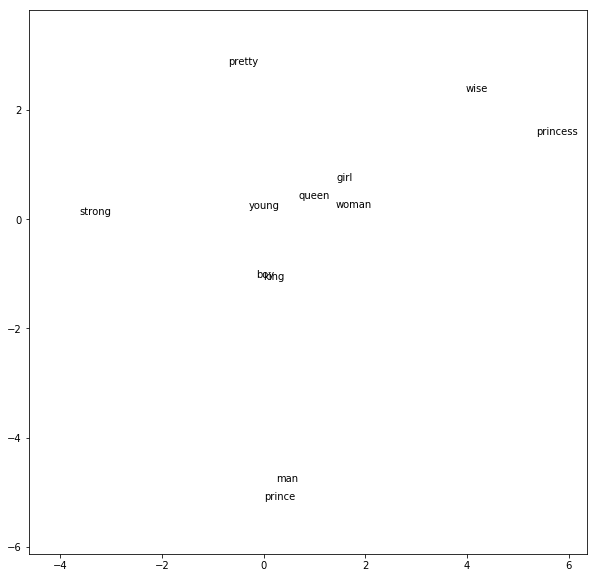

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(df['word'], df['1'], df['2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(word2vec, axis=0)[0] - PADDING
y_axis_min = np.amin(word2vec, axis=0)[1] - PADDING
x_axis_max = np.amax(word2vec, axis=0)[0] + PADDING
y_axis_max = np.amax(word2vec, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()